In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from scipy import stats
from scipy.stats.mstats import winsorize
from scipy.stats import percentileofscore, boxcox, shapiro, probplot, anderson, kstest, mannwhitneyu, yeojohnson
# import statsmodels.api as sm
# from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import sys

sys.path.append("../modules/")

from custom_linear_regression import CustomLinearRegressionWithPValues

sns.set()

## Load raw data

In [2]:
raw_data = pd.read_csv("../NBA/nba.csv")

## Check for missing values

In [3]:
if raw_data.isna().any().any():
    data_no_mv = raw_data.dropna()
else:
    data_no_mv = raw_data

## Preprocessing

In [4]:
data_no_mv["Season_type"] = data_no_mv["Season_type"].str.replace("Regular%20Season", "Regular_Season")

In [5]:
data_no_mv.head()

,year,Season_type,PLAYER_ID,RANK,PLAYER,TEAM_ID,TEAM,GP,MIN,FGM,...,REB,AST,STL,BLK,TOV,PF,PTS,EFF,AST_TOV,STL_TOV
0,2012-13,Regular_Season,201142,1,Kevin Durant,1610612760,OKC,81,3119,731,...,640,374,116,105,280,143,2280,2462,1.34,0.41
1,2012-13,Regular_Season,977,2,Kobe Bryant,1610612747,LAL,78,3013,738,...,433,469,106,25,287,173,2133,1921,1.63,0.37
2,2012-13,Regular_Season,2544,3,LeBron James,1610612748,MIA,76,2877,765,...,610,551,129,67,226,110,2036,2446,2.44,0.57
3,2012-13,Regular_Season,201935,4,James Harden,1610612745,HOU,78,2985,585,...,379,455,142,38,295,178,2023,1872,1.54,0.48
4,2012-13,Regular_Season,2546,5,Carmelo Anthony,1610612752,NYK,67,2482,669,...,460,171,52,32,175,205,1920,1553,0.98,0.30


## Exploring the PDFs of key metrics

In [6]:
# Split data into two halves
half_size = len(data_no_mv) // 2
data_half_1 = data_no_mv.iloc[:half_size, :]
data_half_2 = data_no_mv.iloc[half_size:, :]

"""def test_distributions(data, columns):
    for col in columns:
        print(f"Column: {col}")
        
        # Shapiro-Wilk test for normality on first half
        stat1, p1 = shapiro(data_half_1[col])
        print(f'First Half - Shapiro-Wilk Test: Statistics={stat1}, p={p1}')
        if p1 > 0.05:
            print('First Half - Sample looks Gaussian (fail to reject H0)')
        else:
            print('First Half - Sample does not look Gaussian (reject H0)')
        
        # Shapiro-Wilk test for normality on second half
        stat2, p2 = shapiro(data_half_2[col])
        print(f'Second Half - Shapiro-Wilk Test: Statistics={stat2}, p={p2}')
        if p2 > 0.05:
            print('Second Half - Sample looks Gaussian (fail to reject H0)')
        else:
            print('Second Half - Sample does not look Gaussian (reject H0)')
        
        # Anderson-Darling test for exponential on first half
        result1 = anderson(data_half_1[col], dist='expon')
        print('First Half - Anderson-Darling Test for Exponential:')
        print(f'Statistic: {result1.statistic}')
        for i in range(len(result1.critical_values)):
            sl, cv = result1.significance_level[i], result1.critical_values[i]
            if result1.statistic < cv:
                print(f'{sl}: {result1.statistic} < {cv}, Sample looks Exponential (fail to reject H0)')
            else:
                print(f'{sl}: {result1.statistic} >= {cv}, Sample does not look Exponential (reject H0)')
        
        # Anderson-Darling test for exponential on second half
        result2 = anderson(data_half_2[col], dist='expon')
        print('Second Half - Anderson-Darling Test for Exponential:')
        print(f'Statistic: {result2.statistic}')
        for i in range(len(result2.critical_values)):
            sl, cv = result2.significance_level[i], result2.critical_values[i]
            if result2.statistic < cv:
                print(f'{sl}: {result2.statistic} < {cv}, Sample looks Exponential (fail to reject H0)')
            else:
                print(f'{sl}: {result2.statistic} >= {cv}, Sample does not look Exponential (reject H0)')
        
        print('\n')"""

def test_multiple_distributions(data, columns):
    distributions = ['norm', 'expon', 'logistic', 'gumbel']

    for col in columns:
        print(f"Column: {col}")
        
        for dist in distributions:
            result = anderson(data[col], dist=dist)
            print(f'Anderson-Darling Test for {dist.capitalize()} distribution:')
            print(f'Statistic: {result.statistic}')
            for i in range(len(result.critical_values)):
                sl, cv = result.significance_level[i], result.critical_values[i]
                if result.statistic < cv:
                    print(f'{sl}%: {result.statistic} < {cv}, Sample looks like {dist.capitalize()} (fail to reject H0)')
                else:
                    print(f'{sl}%: {result.statistic} >= {cv}, Sample does not look like {dist.capitalize()} (reject H0)')
            print('\n')

columns_to_check = data_no_mv.columns.drop(["year", "Season_type", "PLAYER", "TEAM", "TEAM_ID", "PLAYER_ID", "RANK"])

# test_multiple_distributions(data_half_1, columns_to_check)

# sns.histplot(data_no_mv["PTS"], stat="density")

In [7]:
# Example of Mann-Whitney U test between two samples
stat, p = mannwhitneyu(data_no_mv['PTS'], data_no_mv['AST'])
print(f'Statistic: {stat}, P-value: {p}')


Statistic: 57673893.5, P-value: 0.0


In [8]:
# sns.histplot(data_no_mv["AST"], stat="density")

In [9]:
# sns.histplot(data_no_mv["TOV"], stat="density")

In [10]:
# sns.histplot(data_no_mv["STL"], stat="density")

In [11]:
# sns.histplot(data_no_mv["BLK"], stat="density")

In [12]:
# sns.histplot(data_no_mv["REB"], stat="density")

In [13]:
# sns.histplot(data_no_mv["PF"], stat="density")

<Axes: xlabel='PTS', ylabel='Density'>

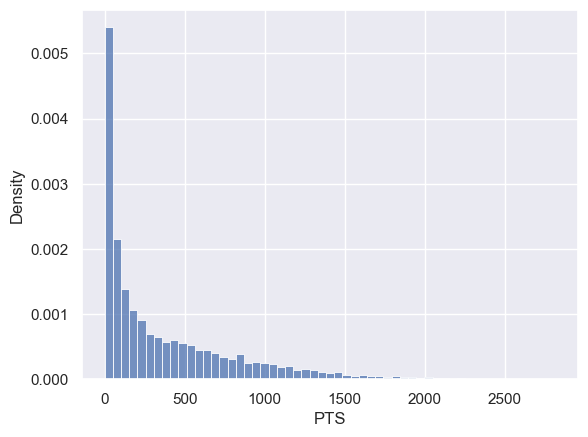

In [14]:
sns.histplot(data_no_mv["PTS"], stat="density")

## Transformation to get normality of key metrics and deal with outliers

<Axes: xlabel='BOX_GP', ylabel='Density'>

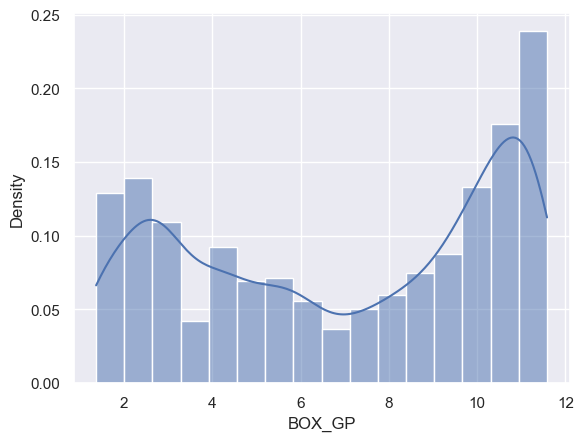

In [15]:
data_transformed = data_no_mv.copy()
# List of columns to transform
columns_to_transform = ["PTS", "AST", "TOV", "STL", "BLK", "REB", "PF", "FGA", "FG3A", "FTA", "FTM", "MIN", "FGM", "FG3M", "GP"]

# Apply Box-Cox transformation and save lambdas
lambdas = {}
for col in columns_to_transform:
    transformed_data, lambdas[f"BOX_{col}"] = boxcox(data_no_mv[col] + 1)  # Adding 1 to avoid zero values
    data_transformed[f"BOX_{col}"] = transformed_data

# Winsorize the transformed data
for col in columns_to_transform:
    data_transformed[f"BOX_{col}"] = winsorize(data_transformed[f"BOX_{col}"], limits=[0.05, 0.01])

# Remove the non-transformed columns
for col in columns_to_transform:
    data_transformed = data_transformed.drop(col, axis=1)

data_transformed = data_transformed.drop(["FG_PCT", "FG3_PCT", "FT_PCT", "OREB", "DREB", "EFF", "AST_TOV", "STL_TOV"], axis=1)

# Robust scale the data
# robust_scaler = RobustScaler()
# data_transformed[[f"BOX_{col}" for col in columns_to_transform]] = robust_scaler.fit_transform(data_transformed[[f"BOX_{col}" for col in columns_to_transform]])


sns.histplot(data_transformed["BOX_GP"], kde=True, stat="density")

In [16]:
# Robust scale the data
"""robust_scaler = RobustScaler()
data_transformed[[f"BOX_{col}" for col in columns_to_transform]] = robust_scaler.fit_transform(data_transformed[[f"BOX_{col}" for col in columns_to_transform]])


sns.histplot(data_transformed["BOX_GP"], kde=True, stat="density")"""

'robust_scaler = RobustScaler()\ndata_transformed[[f"BOX_{col}" for col in columns_to_transform]] = robust_scaler.fit_transform(data_transformed[[f"BOX_{col}" for col in columns_to_transform]])\n\n\nsns.histplot(data_transformed["BOX_GP"], kde=True, stat="density")'

In [17]:
# Function to invert Box-Cox transformation
"""def inverse_boxcox(y, lambda_):
    if lambda_ == 0:
        return np.exp(y) - 1
    else:
        return (y * lambda_ + 1) ** (1 / lambda_) - 1

# Apply the inverse Box-Cox transformation
data_inverse_transformed = data_transformed.copy()
data_trimmed = data_inverse_transformed.drop(["year", "Season_type", "PLAYER_ID", "PLAYER", "RANK", "TEAM_ID", "TEAM"], axis=1)
for col in data_trimmed.columns:
    transformed_col = f'{col}'
    lambda_ = lambdas[col]
    data_trimmed[f'INVERSE_BOX_{col}'] = inverse_boxcox(data_transformed[transformed_col], lambda_)

# Display the transformed and inverse transformed data
data_trimmed["INVERSE_BOX_BOX_PTS"]

data_transformed[[f"BOX_{col}" for col in columns_to_transform]] = robust_scaler.inverse_transform(data_transformed[[f"BOX_{col}" for col in columns_to_transform]])
data_transformed"""

'def inverse_boxcox(y, lambda_):\n    if lambda_ == 0:\n        return np.exp(y) - 1\n    else:\n        return (y * lambda_ + 1) ** (1 / lambda_) - 1\n\n# Apply the inverse Box-Cox transformation\ndata_inverse_transformed = data_transformed.copy()\ndata_trimmed = data_inverse_transformed.drop(["year", "Season_type", "PLAYER_ID", "PLAYER", "RANK", "TEAM_ID", "TEAM"], axis=1)\nfor col in data_trimmed.columns:\n    transformed_col = f\'{col}\'\n    lambda_ = lambdas[col]\n    data_trimmed[f\'INVERSE_BOX_{col}\'] = inverse_boxcox(data_transformed[transformed_col], lambda_)\n\n# Display the transformed and inverse transformed data\ndata_trimmed["INVERSE_BOX_BOX_PTS"]\n\ndata_transformed[[f"BOX_{col}" for col in columns_to_transform]] = robust_scaler.inverse_transform(data_transformed[[f"BOX_{col}" for col in columns_to_transform]])\ndata_transformed'

## View OLS assumptions on scatter plot

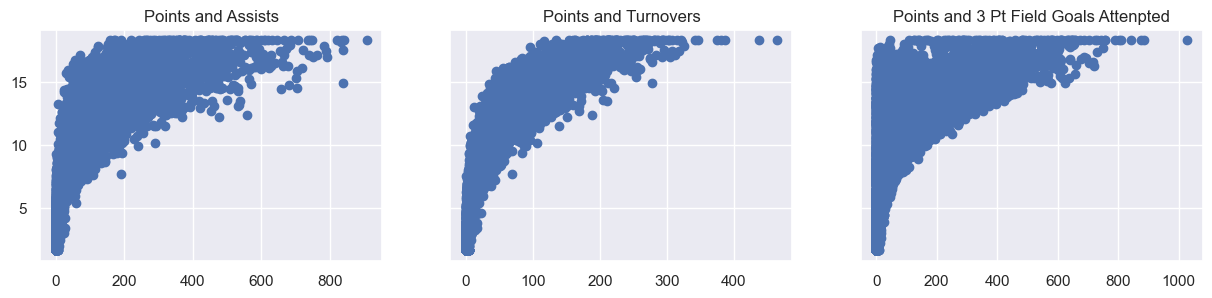

In [18]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,3))
ax1.scatter(data_no_mv["AST"], data_transformed["BOX_PTS"])
ax1.set_title("Points and Assists")

ax2.scatter(data_no_mv["TOV"], data_transformed["BOX_PTS"])
ax2.set_title("Points and Turnovers")

ax3.scatter(data_no_mv["FG3A"], data_transformed["BOX_PTS"])
ax3.set_title("Points and 3 Pt Field Goals Attenpted")

plt.show()

### Multicollinearity

In [19]:

def calculate_vif(X):
    vif = pd.DataFrame()
    vif["Features"] = X.columns
    vif["VIF"] = [1 / (1 - LinearRegression().fit(X.drop(col, axis=1), X[col]).score(X.drop(col, axis=1), X[col])) for col in X.columns]
    return vif 

"""
Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms the original set of features into a new set of uncorrelated features called principal components. The steps involved in PCA are:
    Standardization: Scale the features so they have a mean of 0 and a standard deviation of 1.
    Covariance Matrix Computation: Compute the covariance matrix to understand the relationships between features.
    Eigen Decomposition: Find the eigenvalues and eigenvectors of the covariance matrix. The eigenvectors are the directions of the new feature space, and the eigenvalues indicate the magnitude of variance in these directions.
    Sort and Select: Sort the eigenvalues in descending order and select the top k eigenvalues and corresponding eigenvectors. This determines the number of principal components to retain.
    Transform Data: Project the original data onto the new feature space defined by the top k eigenvectors (principal components).
"""
# Manage data dimensionality with PCA. Principal components are ranked by the amount of variance they capture.
pca = PCA(n_components=10)

data_trimmed = data_transformed.drop(["year", "Season_type", "PLAYER", "TEAM", "BOX_PTS", "BOX_FGM", "BOX_FG3M", "BOX_FTM", "BOX_PF", "TEAM_ID", "PLAYER_ID", "RANK"], axis=1)
vif = calculate_vif(data_trimmed)

# Init standardization
scaler = StandardScaler() 
data_trimmed_scaled = scaler.fit_transform(data_trimmed)

pca_features = pca.fit_transform(data_trimmed)

pca_column_names = [f"PCA_{col}" for col in data_trimmed.columns]

pca_df = pd.DataFrame(pca_features, columns=pca_column_names[:pca_features.shape[1]])

## Add dummies to categorical variables

In [20]:
categoricals = ["year", "Season_type", "TEAM"]

data_with_dummies = pd.get_dummies(data_no_mv[categoricals], drop_first=True)
data_with_dummies = data_with_dummies.astype(int)

data_with_dummies

,year_2013-14,year_2014-15,year_2015-16,year_2016-17,year_2017-18,year_2018-19,year_2019-20,year_2020-21,year_2021-22,year_2022-23,...,TEAM_OKC,TEAM_ORL,TEAM_PHI,TEAM_PHX,TEAM_POR,TEAM_SAC,TEAM_SAS,TEAM_TOR,TEAM_UTA,TEAM_WAS
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8832,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8833,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


#### Concatenate dummies df to PCA df

In [21]:
model_data = pd.concat([pca_df, data_with_dummies], axis=1)
np.exp(model_data)

,PCA_BOX_AST,PCA_BOX_TOV,PCA_BOX_STL,PCA_BOX_BLK,PCA_BOX_REB,PCA_BOX_FGA,PCA_BOX_FG3A,PCA_BOX_FTA,PCA_BOX_MIN,PCA_BOX_GP,...,TEAM_OKC,TEAM_ORL,TEAM_PHI,TEAM_PHX,TEAM_POR,TEAM_SAC,TEAM_SAS,TEAM_TOR,TEAM_UTA,TEAM_WAS
0,1.419495e+08,0.990770,5.751220,0.712488,0.566486,2.341125,0.728076,0.665740,1.158564,0.994787,...,2.718282,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
1,8.769261e+07,0.281327,6.144590,2.172440,0.524934,1.014750,0.911411,1.096131,1.285300,0.936558,...,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
2,1.181531e+08,1.087099,8.425649,1.414058,0.885075,2.111575,0.770264,0.905845,1.272256,1.418091,...,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
3,8.479762e+07,0.196761,5.405194,2.178465,0.554971,1.078241,0.529813,0.782035,1.057667,0.877168,...,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
4,1.760954e+07,0.372875,7.582700,0.355699,0.205426,0.568207,1.433726,0.957895,1.128225,0.798501,...,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8830,6.981627e-09,1.996005,0.653659,1.465286,1.300253,1.073712,1.319144,1.038826,1.141548,1.435160,...,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
8831,6.227590e-09,0.877826,0.839820,1.196742,1.390125,1.017959,1.118661,1.008669,0.968630,1.276493,...,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
8832,7.997517e-09,1.094233,0.602167,1.124961,1.192999,1.301338,1.247423,1.127641,1.092573,1.339837,...,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
8833,4.687414e-09,1.801333,0.791748,1.039423,1.215574,0.619700,1.037650,0.832794,1.211459,1.003165,...,1.000000,1.0,1.0,2.718282,1.0,1.0,1.0,1.0,1.0,1.0


## Assign the features and target

In [22]:
y = data_transformed["BOX_PTS"]
X = model_data

### Split data for training and testing

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Create the regression

In [24]:
reg = CustomLinearRegressionWithPValues()

ridge = Ridge()

# Define the parameter grid
param_grid = {'alpha': [0.1, 1, 10, 100, 1000]}

# Set up GridSearchCV
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring="r2")

# Fit the model 
grid_search.fit(X_train, y_train)
"""reg.fit(X_train, y_train)

r2 = reg.score(X_train, y_train)

coefs = reg.coef_
bias = reg.intercept_
p_values = reg.p
t_values = reg.t"""

'reg.fit(X_train, y_train)\n\nr2 = reg.score(X_train, y_train)\n\ncoefs = reg.coef_\nbias = reg.intercept_\np_values = reg.p\nt_values = reg.t'

### View descriptive stats of model

In [25]:
# Summary DataFrame
"""reg_summary = pd.DataFrame({
        "Feature": list(X.columns),
        "Coefficient": coefs.astype(float).round(4),
        # "Standard Error": standard_errors,
        "p-value": p_values.astype(float).round(3)
})

reg_summary"""


'reg_summary = pd.DataFrame({\n        "Feature": list(X.columns),\n        "Coefficient": coefs.astype(float).round(4),\n        # "Standard Error": standard_errors,\n        "p-value": p_values.astype(float).round(3)\n})\n\nreg_summary'

### Make predictions based on the model

In [26]:
best_model = grid_search.best_estimator_
ridge_y_pred = best_model.predict(X_test)


# box_yhat = reg.predict(X_test)
ridge_residuals = ridge_y_pred - y_test

predictions_summary = pd.DataFrame(X_test, columns=X_test.columns)
predictions_summary.insert(0, "Predicted PTS", ridge_y_pred)
predictions_summary.insert(1, "Actual PTS", y_test)
predictions_summary.insert(2, "PLAYER", data_no_mv["PLAYER"])

# Evaluate the model
mape = mean_absolute_percentage_error(y_test, ridge_y_pred) * 100
mae = mean_absolute_error(y_test, ridge_y_pred)
mse = mean_squared_error(y_test, ridge_y_pred) * 100
r2 = r2_score(y_test, ridge_y_pred)

print(mse, mae, r2, mape)
predictions_summary

11.739145175617761 0.2641362624787372 0.9945143647036749 4.635080008300287


,Predicted PTS,Actual PTS,PLAYER,PCA_BOX_AST,PCA_BOX_TOV,PCA_BOX_STL,PCA_BOX_BLK,PCA_BOX_REB,PCA_BOX_FGA,PCA_BOX_FG3A,...,TEAM_OKC,TEAM_ORL,TEAM_PHI,TEAM_PHX,TEAM_POR,TEAM_SAC,TEAM_SAS,TEAM_TOR,TEAM_UTA,TEAM_WAS
8176,14.975298,14.871463,Bennedict Mathurin,10.954083,-0.978037,0.767821,-0.106081,-1.200562,-0.269494,0.135834,...,0,0,0,0,0,0,0,0,0,0
5884,12.828168,12.789289,Furkan Korkmaz,7.179522,-2.331296,-0.679895,0.135517,-0.573725,-0.083326,-0.671298,...,0,0,1,0,0,0,0,0,0,0
2412,9.233950,8.956791,Joe Young,-0.631800,-1.361476,-0.891823,2.125706,-0.813719,0.494282,0.917206,...,0,0,0,0,0,0,0,0,0,0
538,6.886952,6.953232,Andray Blatche,-8.873817,2.406378,1.956463,0.162820,-0.071095,-0.737947,0.553601,...,0,0,0,0,0,0,0,0,0,0
4354,14.450745,14.106573,Terry Rozier,12.553150,-1.421749,-1.131570,-0.162900,0.440998,0.595877,0.148904,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4567,8.932754,9.276459,Christian Wood,-3.377881,0.633158,0.888891,-1.267879,-1.921835,0.819116,-0.318680,...,0,0,0,0,0,0,0,0,0,0
1152,1.213382,1.608569,DJ White,-19.049598,0.566464,-0.237439,0.162218,0.401502,-0.371476,-0.465370,...,0,0,0,0,0,0,0,0,0,0
5615,4.333949,4.259345,JR Smith,-12.178674,-2.456225,-1.359392,0.521760,0.338524,-0.572000,0.692864,...,0,0,0,0,0,0,0,0,0,0
4657,6.332350,5.564744,Yuta Watanabe,-7.365406,-0.320965,-0.280028,-0.318684,-0.237427,-0.182777,0.239527,...,0,0,0,0,0,0,0,0,0,0


## Inverse transform data

In [27]:

"""First, refit X with new transformations"""
robust_scaler = RobustScaler()
standard_scaler = StandardScaler()
pca = PCA(n_components=52)

categoricals = ["year", "Season_type", "TEAM", "PLAYER"]


# Initialize DataFrame for winsorized data
winsorized_X = X.copy()

# Winsorize the log transformed data
"""for col in columns_to_transform:
    if col not in categoricals:
        winsorized_X[col] = winsorize(X[col], limits=[0.05, 0.01])"""
    
# winsorized_X = winsorize(X, limits=[0.05, 0.01])

robust_scaler.fit(winsorized_X)
robust_scaled_X = robust_scaler.transform(winsorized_X)

standard_scaler.fit(robust_scaled_X)
standard_scaled_X = standard_scaler.transform(robust_scaled_X)

pca.fit(standard_scaled_X)
pca_transformed_X = pca.transform(standard_scaled_X)



# Inverse transforming data after PCA transformation. This will return the scaled data
pca_inverse_transformed = pca.inverse_transform(pca_transformed_X)

# Apply inverse transformation on PCA inverse to get back to the original scale
inverse_standard_scaled_data = standard_scaler.inverse_transform(pca_inverse_transformed)

# Assuming `robust_scaler` was fitted with original data
inverse_robust_scaled_data = robust_scaler.inverse_transform(inverse_standard_scaled_data)

# Apply inverse Winsorization by clamping values back to the thresholds
# Note: In practice, you might not need to explicitly clamp here, as it’s mostly for approximation.
inverse_winsorized_data = np.clip(inverse_robust_scaled_data, a_min=winsorized_X.min().min(), a_max=winsorized_X.max().max())

# Assuming `log_transformed_data` was transformed as np.log(data + 1)
original_data = np.exp(inverse_winsorized_data) - 1

original_data


array([[ 1.41949518e+08, -9.23017257e-03,  4.75121964e+00, ...,
         2.22044605e-16,  0.00000000e+00,  2.22044605e-16],
       [ 8.76926070e+07, -7.18672672e-01,  5.14459011e+00, ...,
         0.00000000e+00,  0.00000000e+00, -1.11022302e-16],
       [ 1.18153058e+08,  8.70987012e-02,  7.42564901e+00, ...,
         2.22044605e-16,  0.00000000e+00,  2.22044605e-16],
       ...,
       [-9.99999992e-01,  9.42333079e-02, -3.97833478e-01, ...,
         0.00000000e+00,  2.22044605e-16,  0.00000000e+00],
       [-9.99999995e-01,  8.01333392e-01, -2.08252338e-01, ...,
         0.00000000e+00,  0.00000000e+00,  4.44089210e-16],
       [-9.99999994e-01,  1.05059891e+00, -2.05751016e-01, ...,
         0.00000000e+00, -1.11022302e-16, -1.11022302e-16]])

In [28]:

mape = mean_absolute_percentage_error(y_test, ridge_y_pred) 
mae = mean_absolute_error(y_test, ridge_y_pred) * 100
rmse = np.sqrt(mean_squared_error(y_test, ridge_y_pred)) * 100
mape_percentage = mape * 100
print(f"MAPE: {mape_percentage:.2f}%")
mae, rmse, mape

MAPE: 4.64%


(26.413626247873722, 34.26243595487303, 0.046350800083002866)

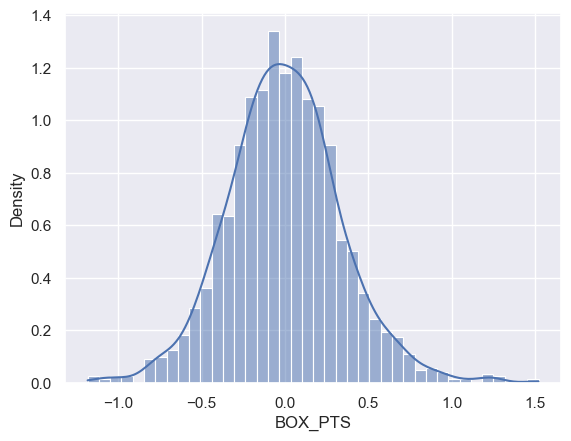

In [29]:
# Residuals plot

sns.histplot(ridge_residuals, kde=True, stat="density")
plt.show()



### Cross validation

In [30]:
cross_val_scores = cross_val_score(ridge, X, y, cv=5, scoring="r2")
cross_val_scores

array([0.99201644, 0.9937869 , 0.99354815, 0.99235224, 0.99094859])

## Hyperparameter Tuning

In [31]:
import joblib

# Retrain Ridge model on full dataset
final_model = best_model.fit(X, y)

# Save the model
joblib.dump(final_model, "final_nba_player_points_model.joblib")

# Deployment - load the model 
loaded_model = joblib.load("final_nba_player_points_model.joblib")